<div style="background-color:#f0f8ff; padding:20px; border-radius:8px; border: 1px solid #dcdcdc; max-width: 800px; margin: auto; text-align: center;">
    <h2 style="font-family: Arial, sans-serif; color: #2c3e50; font-size: 28px; margin-bottom: 10px;">
        Predicting Customer Complaints: A Time Series Approach for Resource Allocation and Service 
        Optimization
    </h2>
</div>

#### Importing Libraries

In [89]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore') 

In [2]:
df = pd.read_csv('../Data/weekly_customer_complaints.csv', index_col=0, parse_dates=True)
df.head()

complaints discount_rate  small_commercial_event  \
week                                                          
2018-01-01      1,750        37.26%                       1   
2018-01-08      1,701        35.38%                       0   
2018-01-15      1,711        36.22%                       1   
2018-01-22      1,443        38.33%                       1   
2018-01-29      1,397        36.34%                       0   

            medium_commercial_event  big_commercial_event  
week                                                       
2018-01-01                        0                     0  
2018-01-08                        0                     0  
2018-01-15                        0                     0  
2018-01-22                        0                     0  
2018-01-29                        0                     0

In [3]:
df.tail()

complaints discount_rate  small_commercial_event  \
week                                                          
2022-11-28      4,444        29.89%                       0   
2022-12-05      4,920        28.48%                       1   
2022-12-12      5,342        28.89%                       0   
2022-12-19      3,868        33.26%                       0   
2022-12-26      3,607        37.35%                       0   

            medium_commercial_event  big_commercial_event  
week                                                       
2022-11-28                        1                     0  
2022-12-05                        0                     0  
2022-12-12                        0                     0  
2022-12-19                        0                     0  
2022-12-26                        1                     0

In [4]:
print(f"Dataset Size: {df.shape}")

Dataset Size: (261, 5)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaints               261 non-null    object
 1   discount_rate            261 non-null    object
 2   small_commercial_event   261 non-null    int64 
 3   medium_commercial_event  261 non-null    int64 
 4   big_commercial_event     261 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 12.2+ KB


In [6]:
df.index

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[ns]', name='week', length=261, freq=None)

#### Data Preprocessing

In [7]:
# Changing time frequency to weekly, starting on Mondays
df = df.asfreq("W-Mon")

In [8]:
# Removing commas from the 'complaints' column and converting to float
df['complaints'] = df['complaints'].str.replace(',', '').astype(float)

In [9]:
#Removing the % symbol in the discount_rate column and convert it to a numeric type (decimal format)
df['discount_rate'] = df['discount_rate'].str.rstrip('%').astype('float') / 100

In [10]:
df.head(3)

complaints  discount_rate  small_commercial_event  \
week                                                            
2018-01-01      1750.0         0.3726                       1   
2018-01-08      1701.0         0.3538                       0   
2018-01-15      1711.0         0.3622                       1   

            medium_commercial_event  big_commercial_event  
week                                                       
2018-01-01                        0                     0  
2018-01-08                        0                     0  
2018-01-15                        0                     0

### Plotting the Time Series

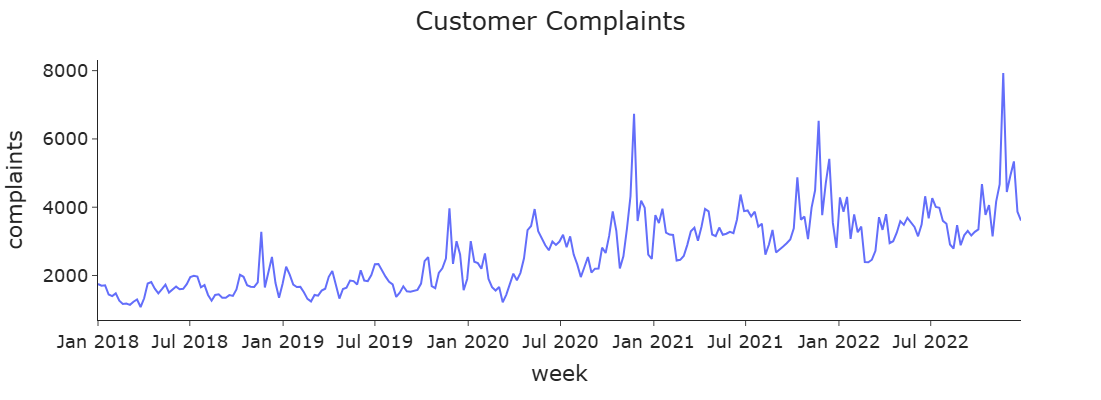

In [11]:
fig = px.line(df, x=df.index, y=df['complaints'])
fig.update_layout( template="simple_white", font=dict(size=18), title_text="Customer Complaints", 
                  width=800, title_x=0.5, height=400)
fig.show()

#### Observations:
* Trend: There is a noticeable upward trend in customer complaints over time, particularly from around mid-2020 onward.
* Seasonality/Spikes: Certain periods, especially in 2021 and 2022, show significant spikes in complaints. These could be seasonal or related to specific events or issues.
* Fluctuations: There is a high level of fluctuation, suggesting that complaints vary significantly on a weekly basis.

### Adding a Moving Average
* Overlaying a moving average (e.g., 4-week moving average) would help smooth out the noise and make the trend clearer.
* A moving average (MA) is a statistical technique used to smooth out fluctuations in data, especially in time-series data, to reveal trends over a specific period. By calculating the average of a set of data points, moving averages help to reduce noise and make underlying patterns more apparent.

In [12]:
df['4_week_MA'] = df['complaints'].rolling(window=4).mean()

In [13]:
df.head()

complaints  discount_rate  small_commercial_event  \
week                                                            
2018-01-01      1750.0         0.3726                       1   
2018-01-08      1701.0         0.3538                       0   
2018-01-15      1711.0         0.3622                       1   
2018-01-22      1443.0         0.3833                       1   
2018-01-29      1397.0         0.3634                       0   

            medium_commercial_event  big_commercial_event  4_week_MA  
week                                                                  
2018-01-01                        0                     0        NaN  
2018-01-08                        0                     0        NaN  
2018-01-15                        0                     0        NaN  
2018-01-22                        0                     0    1651.25  
2018-01-29                        0                     0    1563.00

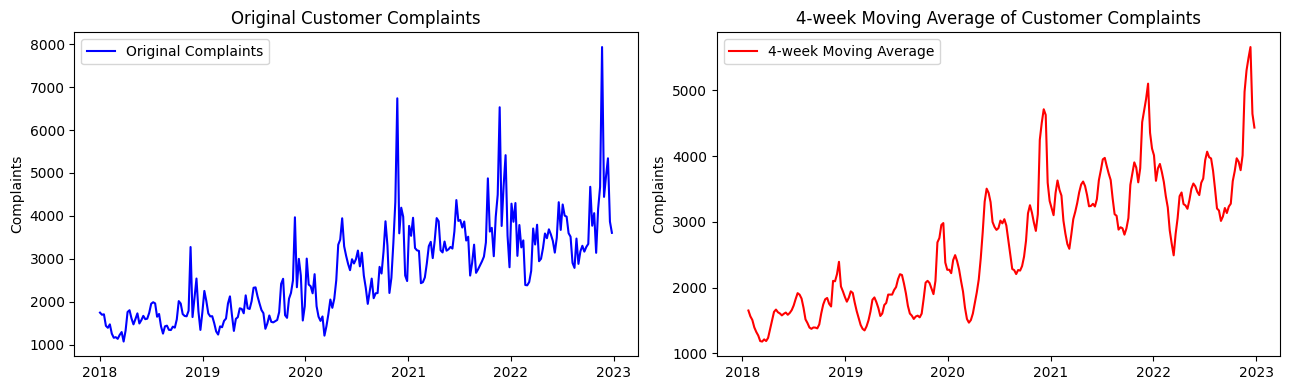

In [14]:
# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(13, 4), sharex=True)

# Plotting original complaints data
axs[0].plot(df.index, df['complaints'], color='blue', label='Original Complaints')
axs[0].set_title('Original Customer Complaints')
axs[0].set_ylabel('Complaints')
axs[0].legend()

# Plotting 4-week moving average
axs[1].plot(df.index, df['4_week_MA'], color='red', label='4-week Moving Average')
axs[1].set_title('4-week Moving Average of Customer Complaints')
axs[1].set_ylabel('Complaints')
axs[1].legend()

plt.tight_layout()
plt.show()

#### Observations:
* The overall trend line reveals a gradual upward trend in complaints, with some periodic increases that align with the spikes seen in the original data.
* This plot suggests that, over time, complaints are increasing, and there might be seasonal or cyclical patterns that could be further analyzed.

### Time-Series Decomposition and Seasonality Analysis

### STL Decomposition
* Separate a time series into three main components: Trend, Seasonal, and Residual (noise).

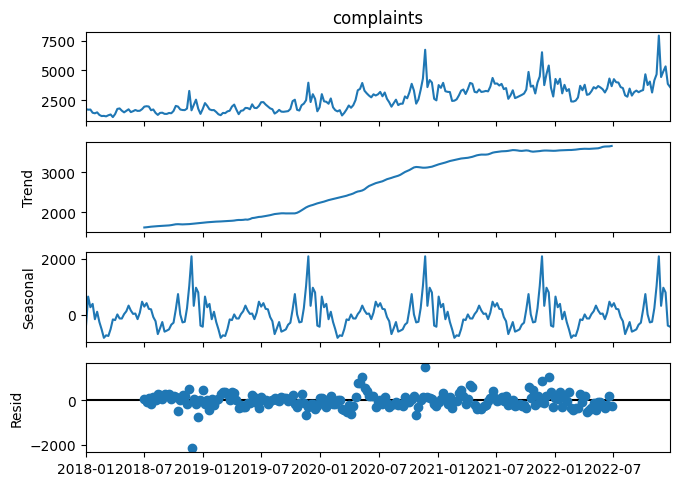

In [15]:
decomposition = sm.tsa.seasonal_decompose(df['complaints'], model='additive', period=52)  # 52 for weekly data

# Plotting the decomposed components
fig = decomposition.plot()
fig.set_size_inches(7, 5)
plt.show()

#### Observation:
#### 1. Trend Component:
* The trend line shows a steady increase in values over time.
#### 2. Seasonal Component:
* The seasonal component exhibits a clear periodic pattern, with peaks and troughs occurring at regular intervals. This cyclical behavior indicates the presence of seasonality, with higher values at specific times.
#### 3. Residual Component:
* The residuals are relatively scattered around zero, indicating that the model effectively captured most of the structure in the trend and seasonal components.
* However, there are some outliers, as shown by occasional large residuals. These could represent unusual events or anomalies that are not explained by the regular trend or seasonality, such as unexpected spikes in complaints due to specific issues.

### Seasonal Cycle Plot
* Visualizing seasonal patterns by grouping data by cycle (here. by months)

* A seasonal cycle plot is a type of visualization used to examine how a time series behaves over different seasons or periods (e.g., months, quarters, or years). It helps to identify recurring patterns or cycles, particularly how values change from one season to the next, over multiple years.
* This plot focuses on visualizing the cyclical behavior or seasonality of the data.

In [16]:
df['month'] = df.index.month
df.head(3)

complaints  discount_rate  small_commercial_event  \
week                                                            
2018-01-01      1750.0         0.3726                       1   
2018-01-08      1701.0         0.3538                       0   
2018-01-15      1711.0         0.3622                       1   

            medium_commercial_event  big_commercial_event  4_week_MA  month  
week                                                                         
2018-01-01                        0                     0        NaN      1  
2018-01-08                        0                     0        NaN      1  
2018-01-15                        0                     0        NaN      1

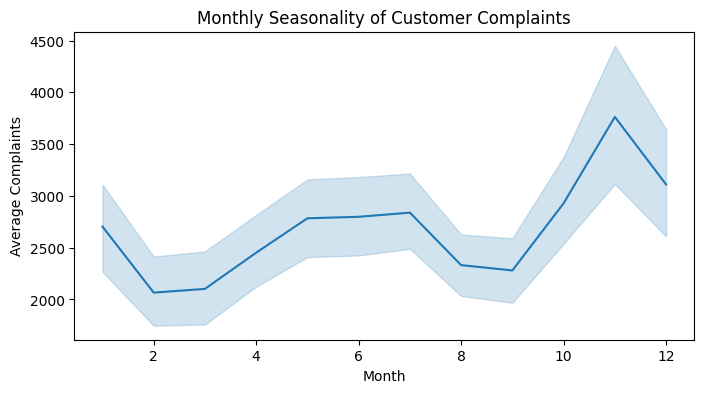

In [17]:
# Plotting monthly seasonality
plt.figure(figsize=(8, 4))
sns.lineplot(x='month', y='complaints', data=df)
plt.title('Monthly Seasonality of Customer Complaints')
plt.xlabel('Month')
plt.ylabel('Average Complaints')
plt.show()

### Key Insights:
#### 1. Seasonal Peaks:
* There’s a noticeable increase in complaints around October to December, with a peak in November. This could indicate seasonal challenges or higher customer expectations during these months, possibly linked to holidays, end-of-year sales, or other events.

#### 2. Lowest Complaint Periods:
* The complaints are at their lowest around February and March. This may reflect a post-holiday period when customer demand and associated issues typically drop.

#### 3. Steady Increase Mid-Year:
* The plot suggests a gradual increase in complaints from around April, peaking towards the end of the year. This trend might correlate with increasing business activity or sales events as the year progresses.

#### 4. Potential Business Implications:
* Resource Planning: Since complaints peak toward the end of the year, company may need additional customer support resources during that period.
* Promotional Strategies: Adjusting marketing and discount rates during high-complaint months could help in managing demand and reducing complaints.
* Event Impact: The seasonal trend could be influenced by commercial events or holiday promotions, suggesting that campaigns may need to be balanced with customer service enhancements.

### Stationarity Test
* Determining if the data is stationary (i.e., its statistical properties don’t change over time), as many time-series models require this.

#### Augmented Dickey-Fuller (ADF) Test:
* The (ADF) test is a statistical test used to determine whether a given time series is stationary or not.
* It specifically tests for the presence of a unit root, which indicates non-stationarity

##### Null Hypothesis (H₀): The series has a unit root (i.e., it is non-stationary).
##### Alternative Hypothesis (H₁): The series does not have a unit root (i.e., it is stationary).
* If the test statistic is sufficiently negative, it suggests that the null hypothesis can be rejected, meaning the series is stationary.

In [18]:
def adf_test(series, significance_level=0.05):
    adf_result = adfuller(series)
    
    # Extracting results
    result = {
        "ADF Statistic": adf_result[0],
        "p-value": adf_result[1],
        "Critical Values": adf_result[4]
    }
    
    # Checking for stationarity
    if adf_result[1] < significance_level:
        stationary = True
        print("The series is stationary (reject the null hypothesis).")
    else:
        stationary = False
        print("The series is not stationary (fail to reject the null hypothesis).")
    
    print(f"\nADF Statistic: {result['ADF Statistic']}")
    print(f"p-value: {result['p-value']}")
    print("Critical Values:")
    for key, value in result["Critical Values"].items():
        print(f"   {key}: {value}")
    
    return result, stationary

In [19]:
result, is_stationary = adf_test(df['complaints'])

The series is not stationary (fail to reject the null hypothesis).

ADF Statistic: -0.9739536482307988
p-value: 0.7626451909029052
Critical Values:
   1%: -3.4573260719088132
   5%: -2.873410402808354
   10%: -2.573095980841316


### Differencing the Series
* Differencing is a key technique in time series analysis to make a non-stationary series stationary by removing trends and seasonality.
* For a time series with seasonal patterns like this, seasonal differencing is a good approach. The goal is to remove the seasonal component from the series to make the data stationary.
* Applying seasonal differencing with 𝑠 = 52.

#### Seasonal Differencing:
* Method: Subtracts the value of the current period from the value of the same period in the previous cycle (e.g., subtracting the value 12 months back in monthly data).

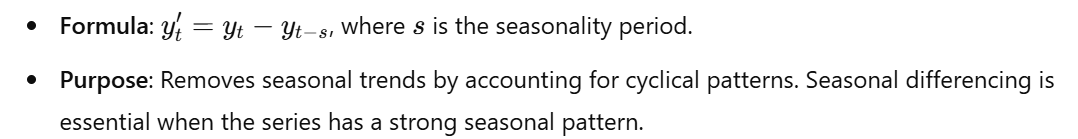

In [20]:
# Applying seasonal differencing with period s = 52 
df['complaints_diff'] = df['complaints'] - df['complaints'].shift(52)

#### Re-checking Stationarity using the ADF test

In [21]:
# Dropping the NaN values temporarily for the ADF test
complaints_diff_non_na = df['complaints_diff'].dropna()

In [22]:
result, is_stationary = adf_test(complaints_diff_non_na)

The series is stationary (reject the null hypothesis).

ADF Statistic: -5.375059062872164
p-value: 3.820646188922235e-06
Critical Values:
   1%: -3.4623415245233145
   5%: -2.875606128263243
   10%: -2.574267439846904


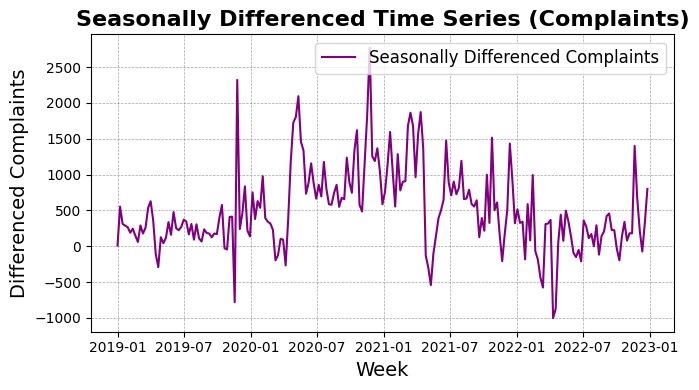

In [23]:
plt.figure(figsize=(7, 4))

# Plotting the seasonally differenced data
plt.plot(df['complaints_diff'], label='Seasonally Differenced Complaints', color='purple', linestyle='-', linewidth=1.5)

plt.title('Seasonally Differenced Time Series (Complaints)', fontsize=16, fontweight='bold')
plt.xlabel('Week', fontsize=14)
plt.ylabel('Differenced Complaints', fontsize=14)
plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#### Plotting ACF and PACF

#### ACF Plot (Auto-Correlation Function) and PACF:

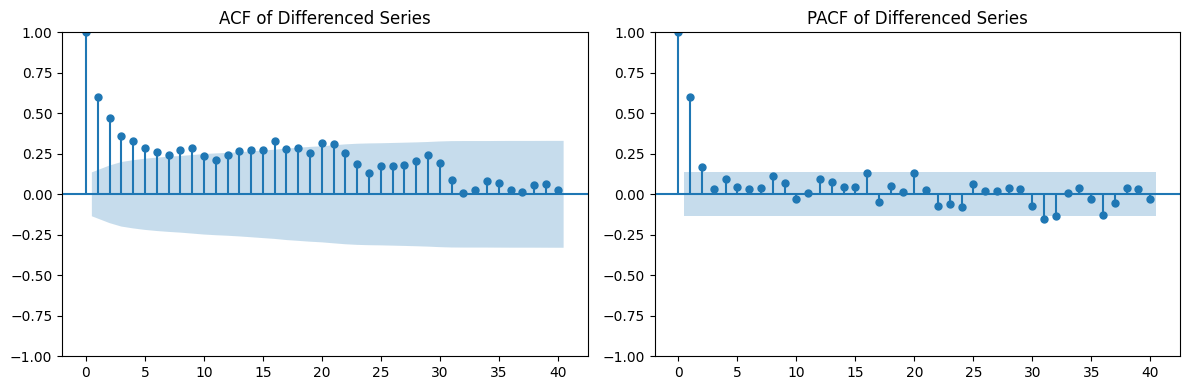

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plot_acf(df['complaints_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF of Differenced Series')

plt.subplot(1, 2, 2)
plot_pacf(df['complaints_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF of Differenced Series')

plt.tight_layout()
plt.show()

#### Some Insights from plots:
#### 1. ACF Plot (Left): 
* The ACF plot shows a significant spike at lag 1, with subsequent lags gradually declining. This pattern suggests that the series may have a moving average (MA) component, as the initial high autocorrelation at lag 1 is followed by a steady decay.
* Since the decay is gradual rather than abrupt, it might indicate a higher-order MA process (possibly q=1 or higher).

#### 2. PACF Plot (Right): 
* The PACF plot has a significant spike at lag 1, followed by values within the confidence interval. This indicates an autoregressive (AR) component, with p=1 as a good starting point.
* Since only the first lag in PACF is significant, a simple AR(1) model might capture the autoregressive component effectively.

### Data Split

In [25]:
split_index = int(len(df)* 0.8)

# Splitting into training and test sets
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

print("Training set dates:", train_df.index.min(), "to", train_df.index.max())
print("Test set dates:", test_df.index.min(), "to", test_df.index.max())

Training set dates: 2018-01-01 00:00:00 to 2021-12-20 00:00:00
Test set dates: 2021-12-27 00:00:00 to 2022-12-26 00:00:00


In [26]:
print(f"Training Set Size: {train_df.shape}")
print(f"Test Set Size: {test_df.shape}")

Training Set Size: (208, 8)
Test Set Size: (53, 8)


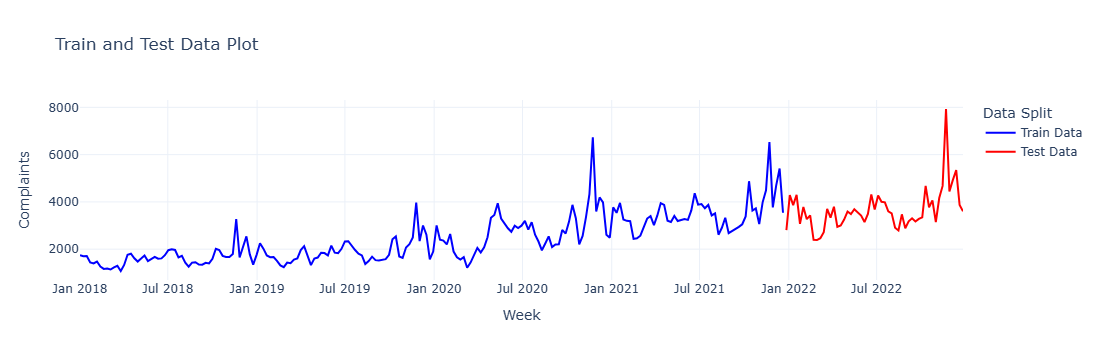

In [27]:
fig = go.Figure()
#Training data
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['complaints'],
                         mode='lines', name='Train Data', line=dict(color='blue')))
#Testing data
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['complaints'],
                         mode='lines', name='Test Data', line=dict(color='red')))

fig.update_layout(
    title="Train and Test Data Plot", xaxis_title="Week", yaxis_title="Complaints", 
    legend_title="Data Split", template="plotly_white")
fig.show()

#### Evaluation Metrics for Time Series
* For time series forecasting, typical evaluation metrics include:
1. Mean Absolute Error (MAE)                   <img src="../Images/img-2.png" width=200 height=100>
 
<img src="../Images/img-3.png" width=400 height=200>

#### Function for Evaluation Metrics (Helper Function)

In [28]:
def evaluate_forecast(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}")

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape
    }

In [29]:
# Initializing a dictionary to store results
model_results = {}

In [31]:
def plot_forecast_matplotlib(train_df, test_df, forecasted_values, title="Training, Testing and Forecasted Data", x_title="Week", y_title="Complaints", legend_titles=None):
    if legend_titles is None:
        legend_titles = ['Train Data', 'Test Data', 'Forecast']
    plt.figure(figsize=(8, 4))

    # Plotting train data
    plt.plot(train_df.index, train_df['complaints'], label=legend_titles[0], color='blue')

    # Plotting test data (actual values)
    plt.plot(test_df.index, test_df['complaints'], label=legend_titles[1], color='lightgreen')

    # Plotting forecasted values
    plt.plot(test_df.index, forecasted_values, label=legend_titles[2], color='red', linestyle='--')

    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Model Selection and Fitting ⚙️

### 1. Holt-Winters Exponential Smoothing 
*  Starting with Holt-Winters provides a baseline forecast.
*  Stationarity Not Required: Holt-Winters does not require the data to be stationary, as it models trends and seasonality directly.
* Our series has both trend and seasonality, we can use Holt-Winters Exponential Smoothing directly on the original (non-differenced) data.
* Winter’s exponential smoothing is built on top of both single and double exponential smoothing, Winter’s method is thus also known as triple exponential smoothing.
* Winter’s method assumes that the time series has a level, trend and seasonal component. A forecast with Winter’s exponential smoothing can be expressed as:
  <img src="../Images/img-4.png" width=600>


In [32]:
hw_model = ExponentialSmoothing(
    train_df['complaints'], seasonal='mul',  trend='add',  seasonal_periods=52  )

hw_fitted_model = hw_model.fit()

# Forecasting for the length of the test set
hw_predictions = hw_fitted_model.forecast(steps = len(test_df))

In [33]:
y_true = test_df['complaints']
result = evaluate_forecast(y_true, hw_predictions)
model_results['Holt-Winters'] = list(result.values())

MAE: 406.871742510799
MSE: 241901.14256711863
RMSE: 491.83446663193365
MAPE: 11.936129519479985


In [34]:
# Print the AIC score
print("AIC Score:", hw_fitted_model.aic)

AIC Score: 2486.7997656054918


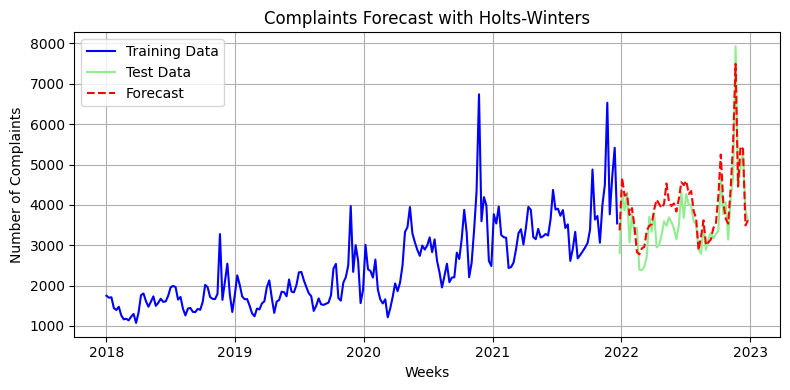

In [35]:
plot_forecast_matplotlib(train_df, test_df, 
                hw_predictions, title="Complaints Forecast with Holts-Winters", x_title="Weeks",
        y_title="Number of Complaints", legend_titles=["Training Data", "Test Data", "Forecast"])

#### Observations:
* The forecast (in red) appears to generally follow the seasonal pattern and trend of the test data (in green), indicating that the model captures the seasonality well.
* The peaks and troughs in the forecast are aligned with the actual data, which suggests that the chosen multiplicative seasonality is indeed appropriate.
* The additive trend helps capture the gradual increase in complaints over time, though it may not fully capture more drastic jumps or drops in complaint numbers.

### 2. SARIMA Model (Seasonal AutoRegressive Integrated Moving Average)
* Our complaint data exhibits seasonality along with trend component. 
* SARIMA is an extension of the ARIMA model, specifically designed to handle data with both non-seasonal and seasonal patterns. It is widely used for time series forecasting when data shows repeating seasonal trends (e.g., monthly sales patterns, weekly demand in a year).
#### SARIMA Parameters:
1. Non-seasonal parameters (p, d, q): Together, (p, d, q) make up the basic ARIMA model, which is effective for non-seasonal data.
2. Seasonal parameters (P, D, Q, s): The seasonal component (P, D, Q, s) helps SARIMA capture periodic patterns in the data, allowing it to make better predictions in seasonal time series than a standard ARIMA model.

<img src= "../Images/img-5.png" width=300 >

#### From ACF and PACF plots, plotted above the starting value for p and q should be 1.

In [36]:
sarima_model = SARIMAX(
    train_df['complaints'],
    order=(1, 1, 1),               # Set based on ACF n PACF plots..
    seasonal_order=(1, 1, 1, 52), 
    enforce_stationarity=False,
    enforce_invertibility=False)

sarima_fitted_model = sarima_model.fit()

# Forecasting for the length of the test set
sarima_predictions = sarima_fitted_model.forecast(steps = len(test_df))

In [37]:
y_true = test_df['complaints']
result = evaluate_forecast(y_true, sarima_predictions)
model_results['SARIMA(1,1,1)X(1,1,1,52)'] = list(result.values())

MAE: 701.4710062135205
MSE: 582560.5784380207
RMSE: 763.2565613461968
MAPE: 20.783368810543006


In [38]:
# Print the AIC score
print("AIC Score:", sarima_fitted_model.aic)

AIC Score: 1528.820246144324


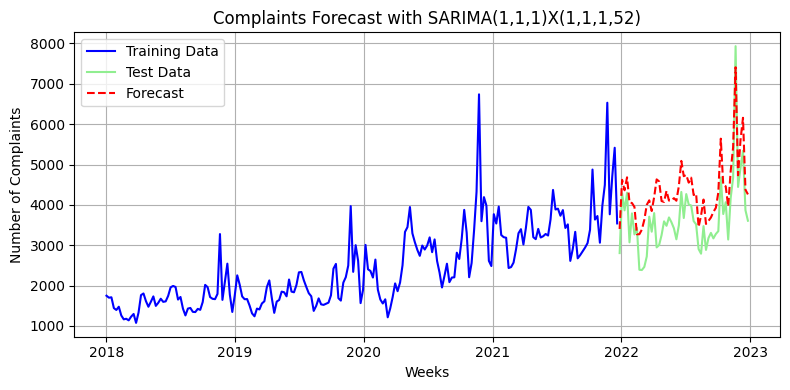

In [39]:
plot_forecast_matplotlib(train_df, test_df, sarima_predictions, 
                         title="Complaints Forecast with SARIMA(1,1,1)X(1,1,1,52)", x_title="Weeks",
        y_title="Number of Complaints", legend_titles=["Training Data", "Test Data", "Forecast"])

#### Observations:
#### SARIMA Forecast: 
* The SARIMA model attempts to follow the general trend in the test data, including the seasonal peaks, but it has noticeable deviations. There are points where SARIMA’s forecast is higher  than the actual test values, particularly at some of the peaks.
*  The forecast lines from SARIMA don’t perfectly capture the amplitude of seasonal peaks as observed in the actual data.
#### Model Comparison:
*  Lower RMSE for Holt-Winters again implies that this model has better predictive accuracy on average in terms of error magnitude.
*  Holt-Winters has a significantly lower MAPE, showing better performance in terms of relative accuracy (percent error) compared to SARIMA.
*  SARIMA has a much lower AIC, indicating a better balance between goodness-of-fit and model complexity. However, this lower AIC doesn't necessarily mean better forecasting accuracy, as reflected in the other metrics.
*  Holt-Winters is visually and statistically the better model for forecasting in this scenario, offering a more accurate representation of seasonal variations and peak complaint volumes.

#### Let's go with Auto ARIMA to select optimal SARIMA model parameters.

### 3. Auto ARIMA
* Auto SARIMA automatically selects the optimal SARIMA model parameters (p, d, q, P, D, Q, and seasonal period) based on statistical criteria such as the Akaike Information Criterion (AIC), which can help improve model accuracy without manual tuning.
* Automatic Parameter Selection: Auto SARIMA will evaluate multiple combinations of parameters to minimize the AIC, helping to find the best model fit for your data without extensive manual trial and error.

In [46]:
auto_model = pm.auto_arima(y=train_df['complaints'],  
                           seasonal=True,  # Enabling seasonal model
                           m=52,           # Seasonal period (52 weeks for weekly data)
                           stepwise=True,  # Using stepwise search to reduce computation time
                           trace=True)     # Enabling tracing to see progress

# Summarizes the model
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=15.30 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3240.632, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=3.83 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=3.68 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3238.677, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=3.17 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=5.33 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=3163.619, Time=4.51 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=40.36 sec
 ARIMA(0,1,0)(1,0,2)[52] intercept   : AIC=inf, Time=34.95 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=inf, Time=16.61 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=3161.131, Time=11.93 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=3141.030, Time=17.05 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=41.40 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=3141.503, Time

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  208
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 52)   Log Likelihood               -1552.942
Date:                             Sat, 16 Nov 2024   AIC                           3115.884
Time:                                     10:12:44   BIC                           3132.547
Sample:                                 01-01-2018   HQIC                          3122.622
                                      - 12-20-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4085      0.064      6.336      0.000       0.282       0.535
ar.L2          0.1117      0.082      1.365      0.172      -0.049       0.272
ma.L1         -0.9357      0.039    -24.296      0.000      -1.011      -0.860
ar.S.L52       0.6380      0.036     17.864      0.000       0.568       0.708
sigma2      1.682e+05   8356.537     20.133      0.000    1.52e+05    1.85e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               453.47
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               4.60   Skew:                             1.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
# Forecasting with the Auto SARIMA model
n_periods = len(test_df)  # Forecasting for the length of test set
auto_arima_forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

In [48]:
y_true = test_df['complaints']
result = evaluate_forecast(y_true, auto_arima_forecast)
model_results['Auto SARIMA(2,1,1)X(1,0,0,52)'] = list(result.values())

MAE: 503.72305941179803
MSE: 410234.1671724119
RMSE: 640.4952514831097
MAPE: 15.428715415051103


In [49]:
# Print the AIC score
print("AIC Score:", auto_model.aic())

AIC Score: 3115.8835832381055


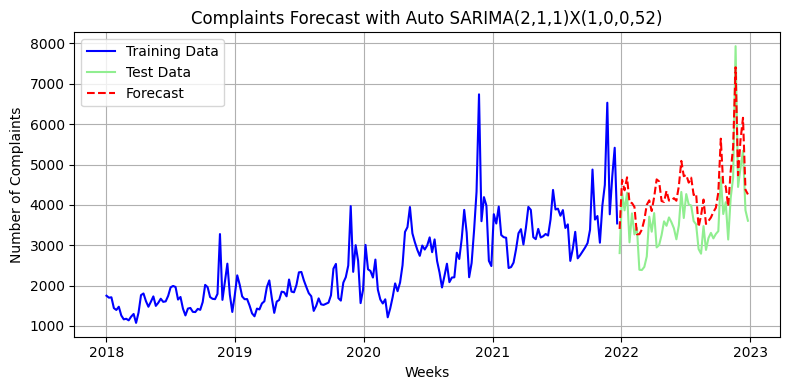

In [50]:
plot_forecast_matplotlib(train_df, test_df, sarima_predictions, 
                         title="Complaints Forecast with Auto SARIMA(2,1,1)X(1,0,0,52)", x_title="Weeks",
        y_title="Number of Complaints", legend_titles=["Training Data", "Test Data", "Forecast"])

#### Observations:
* The model captures the trend and seasonality effectively, as demonstrated by the alignment between the test data and forecast.
* A slightly higher RMSE compared to MAE shows the impact of larger errors on model evaluation.
* On average, the model's predictions are 15.43% off from the actual values.

### Let's Explore other features(i.e discount rates, event types).
#### Does these features have any impact on our forecast??

#### Analyzing whether the Discount Rate has any impact on the number of complaints?

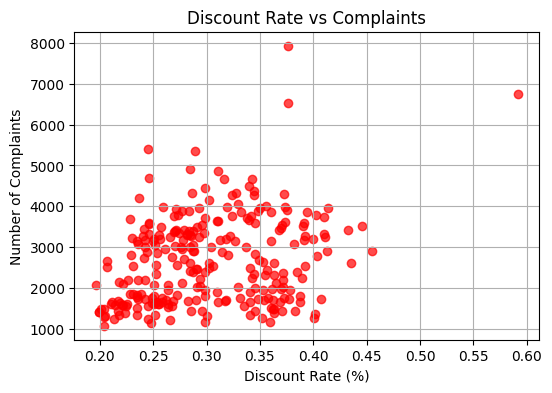

Correlation between Discount Rate and Complaints: 0.28


In [51]:
plt.figure(figsize=(6, 4))
plt.scatter(df['discount_rate'], df['complaints'], color='red', alpha=0.7)
plt.title('Discount Rate vs Complaints')
plt.xlabel('Discount Rate (%)')
plt.ylabel('Number of Complaints')
plt.grid()
plt.show()

correlation = df['discount_rate'].corr(df['complaints'])
print(f"Correlation between Discount Rate and Complaints: {correlation:.2f}")

* A correlation of 0.28 between discount rate and complaints indicates a weak positive relationship. This suggests that as the discount rate increases, the number of complaints tends to slightly increase, but the relationship is not very strong.

#### Analyzing Commercial Events

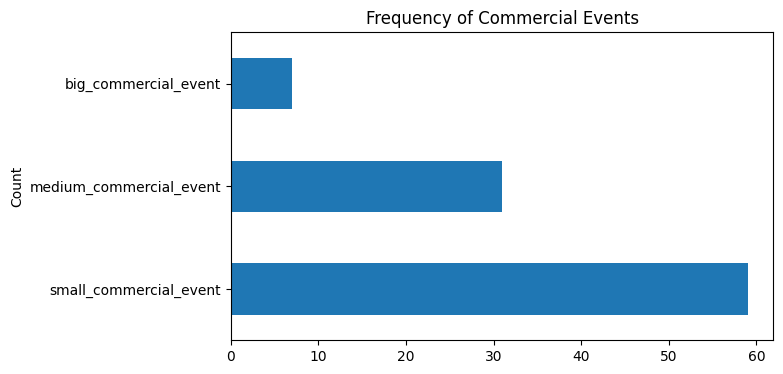

In [52]:
event_counts = df[['small_commercial_event', 'medium_commercial_event', 'big_commercial_event']].sum()
event_counts.plot(kind='barh', figsize=(7, 4), title='Frequency of Commercial Events')
plt.ylabel('Count')
plt.show()

In [53]:
event_counts

small_commercial_event     59
medium_commercial_event    31
big_commercial_event        7
dtype: int64

#### Average Complaints for Each Event

In [54]:
event_types = ['small_commercial_event', 'medium_commercial_event', 'big_commercial_event']
for event in event_types:
    avg_complaints = df[df[event] == 1]['complaints'].mean()
    print(f"Average complaints during {event.replace('_', ' ')}: {avg_complaints:.2f}")

Average complaints during small commercial event: 2310.71
Average complaints during medium commercial event: 3327.10
Average complaints during big commercial event: 3737.14


#### Insights:
#### Small Commercial Events: 
* Generate the lowest complaints on average. These might involve less marketing hype and manageable demand.
#### Medium Commercial Events:
* See a rise in complaints, likely due to increased customer engagement, resulting in potential issues like supply shortages or unmet expectations.
#### Big Commercial Events: 
* Generate the highest complaints, likely due to operational overload, increased product demand, or heightened customer expectations during these major events.

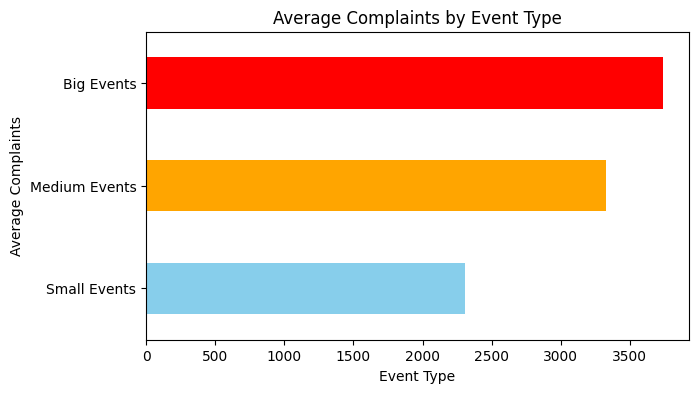

In [55]:
event_impact = {
    'Small Events': df[df['small_commercial_event'] == 1]['complaints'].mean(),
    'Medium Events': df[df['medium_commercial_event'] == 1]['complaints'].mean(),
    'Big Events': df[df['big_commercial_event'] == 1]['complaints'].mean(),
}

pd.Series(event_impact).plot(kind='barh', figsize=(7, 4), color=['skyblue', 'orange', 'red'])
plt.title('Average Complaints by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Average Complaints')
plt.show()

In [56]:
for event in event_types:
    correlation = df[df[event] == 1]['discount_rate'].corr(df[df[event] == 1]['complaints'])
    print(f"Correlation between Discount Rate and Complaints during {event.replace('_', ' ')}: {correlation:.2f}")

Correlation between Discount Rate and Complaints during small commercial event: 0.07
Correlation between Discount Rate and Complaints during medium commercial event: 0.37
Correlation between Discount Rate and Complaints during big commercial event: -0.65


#### Based on our observations from the above plots and the correlation analysis, the external variables(exogenous variables) they have some impact on complaints though not high as I expected.
* This suggests that discount rate is a exogenous variable. Its impact, however, varies depending on the event type.
* The average complaints differ significantly for small, medium, and big commercial events.
* Including these categorical variables can help capture how different event types influence complaints.
#### Interactions:
* The interaction between event types and discount rate appears critical:
* Big events: Higher discounts reduce complaints (negative interaction).
* Medium events: Higher discounts increase complaints (positive interaction).
* Adding interaction terms (like, medium_commercial_event * discount_rate) will allow the model to account for these effects.

### 4. SARIMAX 
* SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) is a powerful time series forecasting model.
* It extends the SARIMA model by allowing the inclusion of external variables (exogenous regressors) that may influence the series being modeled.

####  Exogenous Variables Based on the analysis:
1. discount_rate
2. Event Types
3. discount_rate * medium_commercial_event
4. discount_rate * big_commercial_event

In [61]:
df['medium_discount_interaction'] = df['discount_rate'] * df['medium_commercial_event']
df['big_discount_interaction'] = df['discount_rate'] * df['big_commercial_event']

In [63]:
exog = df[['discount_rate', 'small_commercial_event', 'medium_commercial_event', 
           'big_commercial_event', 'medium_discount_interaction', 'big_discount_interaction']]

In [72]:
# Aligning the Indices
exog_train = exog.loc[train_df.index]

In [78]:
exog_test = exog.loc[test_df.index]

#### SARIMA model with manual order

In [76]:
model = SARIMAX(
    endog = train_df['complaints'],
    exog  = exog_train,
    order = (1, 1, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_fitted_manual_model = model.fit()
sarimax_fitted_manual_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         complaints   No. Observations:                  208
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -732.263
Date:                            Sat, 16 Nov 2024   AIC                           1486.526
Time:                                    10:28:27   BIC                           1515.292
Sample:                                01-01-2018   HQIC                          1498.171
                                     - 12-20-2021                                         
Covariance Type:                              opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
discount_rate                4185.6224    719.683      5.816      0.000    2775.070    5596.175
small_commercial_event        208.6658     63.106      3.307      0.001      84.981     332.351
medium_commercial_event        18.6231    527.663      0.035      0.972   -1015.577    1052.823
big_commercial_event         -359.8230   2914.130     -0.123      0.902   -6071.412    5351.766
medium_discount_interaction   669.0888   1674.479      0.400      0.689   -2612.829    3951.006
big_discount_interaction     2431.8671   7656.202      0.318      0.751   -1.26e+04    1.74e+04
ar.L1                           0.7496      0.078      9.666      0.000       0.598       0.902
ma.L1                          -1.0153      0.029    -34.930      0.000      -1.072      -0.958
ar.S.L52                       -0.6372      0.148     -4.316      0.000      -0.927      -0.348
ma.S.L52                        1.6101      1.239      1.299      0.194      -0.819       4.039
sigma2                       3.822e+04   4.73e+04      0.808      0.419   -5.45e+04    1.31e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.63   Prob(JB):                         0.39
Heteroskedasticity (H):               1.47   Skew:                             0.14
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
steps = len(test_df) 
sarimax_manual_forecast = sarimax_fitted_manual_model.get_forecast(steps=steps, exog=exog_test)

# Extracting predicted mean as array-like
forecast_values = sarimax_manual_forecast.predicted_mean

y_true = test_df['complaints']
forecast_values = forecast_values.to_numpy()  # Converting to NumPy array if not already

result = evaluate_forecast(y_true, forecast_values)
model_results['SARIMAX(1,1,1)X(1,1,1,52)_Manual'] = list(result.values())

MAE: 679.3140424085793
MSE: 545687.5754443337
RMSE: 738.7066910786268
MAPE: 19.761714104611755


In [98]:
# Print the AIC score
print("AIC Score:", sarimax_fitted_manual_model.aic)

AIC Score: 1486.5256141019765


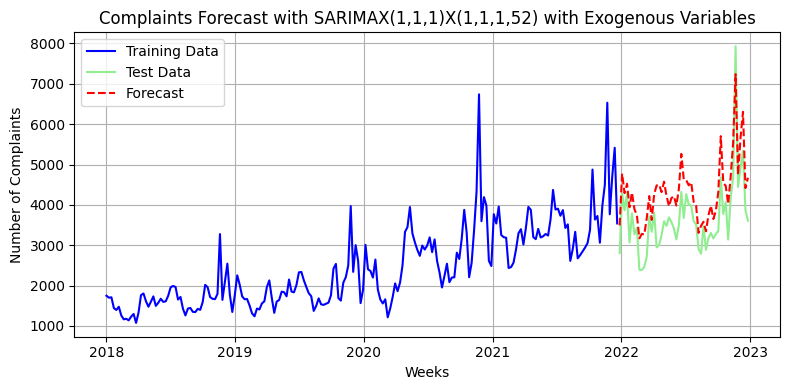

In [99]:
plot_forecast_matplotlib(train_df, test_df, forecast_values, 
                         title="Complaints Forecast with SARIMAX(1,1,1)X(1,1,1,52) with Exogenous Variables",
                         x_title="Weeks", y_title="Number of Complaints", 
                         legend_titles=["Training Data", "Test Data", "Forecast"])

#### SARIMAX model with auto_arima order

In [90]:
auto_model_order = auto_arima(train_df['complaints'], 
                              exogenous=exog_train, 
                              seasonal=True, 
                              m=52, 
                              trace=True).order

auto_seasonal_order = auto_arima(train_df['complaints'], 
                                 exogenous=exog_train, 
                                 seasonal=True, 
                                 m=52, 
                                 trace=True).seasonal_order

auto_sarimax_model = SARIMAX(train_df['complaints'], 
                     exog=exog_train, 
                     order=auto_model_order, 
                     seasonal_order=auto_seasonal_order).fit()

auto_sarimax_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=13.98 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3240.632, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=3.66 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=3.43 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3238.677, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=2.46 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=7.21 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=3163.619, Time=5.21 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=46.27 sec
 ARIMA(0,1,0)(1,0,2)[52] intercept   : AIC=inf, Time=37.65 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=inf, Time=29.15 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=3161.131, Time=15.77 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=3141.030, Time=18.69 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=43.83 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=3141.503, Time

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          complaints   No. Observations:                  208
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 52)   Log Likelihood               -1535.236
Date:                             Sat, 16 Nov 2024   AIC                           3092.472
Time:                                     11:04:33   BIC                           3129.132
Sample:                                 01-01-2018   HQIC                          3107.297
                                      - 12-20-2021                                         
Covariance Type:                               opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
discount_rate                6606.0409    618.999     10.672      0.000    5392.825    7819.256
small_commercial_event        140.5315     65.130      2.158      0.031      12.879     268.184
medium_commercial_event      -167.5736    427.308     -0.392      0.695   -1005.081     669.934
big_commercial_event         -698.1880   3638.170     -0.192      0.848   -7828.870    6432.494
medium_discount_interaction  1207.5587   1393.191      0.867      0.386   -1523.046    3938.163
big_discount_interaction     3070.8265   1.03e+04      0.297      0.767   -1.72e+04    2.34e+04
ar.L1                          -0.5089      0.530     -0.960      0.337      -1.547       0.530
ar.L2                          -0.1737      0.147     -1.179      0.238      -0.462       0.115
ma.L1                           0.1679      0.543      0.309      0.757      -0.896       1.232
ar.S.L52                        0.6161      0.053     11.694      0.000       0.513       0.719
sigma2                       1.434e+05   1.03e+04     13.945      0.000    1.23e+05    1.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               113.56
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.54   Skew:                             0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
steps = len(test_df) 
sarimax_auto_forecast = auto_sarimax_model.get_forecast(steps=steps, exog=exog_test)

# Extracting predicted mean as array-like
forecast_values_auto = sarimax_auto_forecast.predicted_mean

y_true = test_df['complaints']
forecast_values_auto = forecast_values_auto.to_numpy()  # Converting to NumPy array if not already

result = evaluate_forecast(y_true, forecast_values_auto)
model_results['SARIMAX(2,1,1)X(1,0,0,52)_Auto'] = list(result.values())

MAE: 925.9305385704535
MSE: 976903.4745770525
RMSE: 988.3842747520079
MAPE: 27.643923748984072


In [104]:
# Print the AIC score
print("AIC Score:", auto_sarimax_model.aic)

AIC Score: 3092.4724678200237


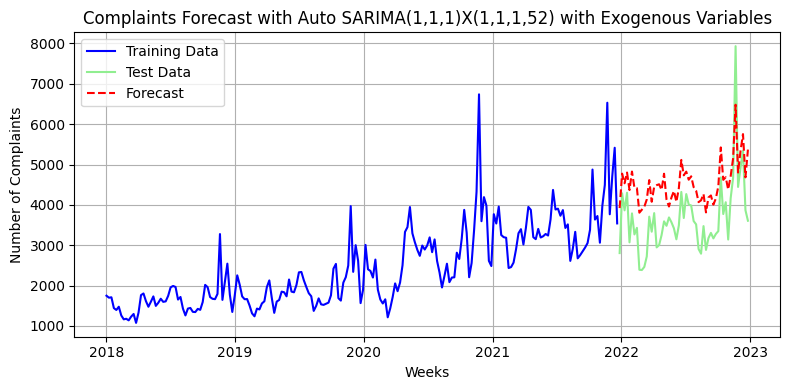

In [105]:
plot_forecast_matplotlib(train_df, test_df, forecast_values_auto, 
        title="Complaints Forecast with Auto SARIMA(1,1,1)X(1,1,1,52) with Exogenous Variables",
        x_title="Weeks", y_title="Number of Complaints", 
        legend_titles=["Training Data", "Test Data", "Forecast"])

#### Observations:
* The manual SARIMAX model performs better across all metrics compared to the auto SARIMAX model.
* The manual SARIMAX(1,1,1)X(1,1,1,52) achieves both lower AIC and better forecasting accuracy. It strikes a better balance between fit and simplicity.
* The auto SARIMAX(2,1,1)X(1,0,0,52), despite being more complex (as seen from a much higher AIC), does not outperform the manual model. This suggests that the complexity of the auto model may not be justified.
* The forecast seen from the plot also tells that Auto SARIMAX has poor forecast especially the seasonality.

In [106]:
model_results

{'Holt-Winters': [406.871742510799,
  241901.14256711863,
  491.83446663193365,
  11.936129519479985],
 'SARIMA(1,1,1)X(1,1,1,52)': [701.4710062135205,
  582560.5784380207,
  763.2565613461968,
  20.783368810543006],
 'Auto SARIMA(2,1,1)X(1,0,0,52)': [503.72305941179803,
  410234.1671724119,
  640.4952514831097,
  15.428715415051103],
 'SARIMAX(1,1,1)X(1,1,1,52)_Manual': [679.3140424085793,
  545687.5754443337,
  738.7066910786268,
  19.761714104611755],
 'SARIMAX(2,1,1)X(1,0,0,52)_Auto': [925.9305385704535,
  976903.4745770525,
  988.3842747520079,
  27.643923748984072]}

In [107]:
model_results_df = pd.DataFrame(model_results).transpose()
model_results_df.rename(columns={0:'MAE', 1:'MSE', 2:'RMSE', 3:'MAPE'}, inplace = True)
model_results_df.sort_values(by= 'RMSE', ascending = True, inplace = True)

In [108]:
model_results_df

MAE            MSE        RMSE  \
Holt-Winters                      406.871743  241901.142567  491.834467   
Auto SARIMA(2,1,1)X(1,0,0,52)     503.723059  410234.167172  640.495251   
SARIMAX(1,1,1)X(1,1,1,52)_Manual  679.314042  545687.575444  738.706691   
SARIMA(1,1,1)X(1,1,1,52)          701.471006  582560.578438  763.256561   
SARIMAX(2,1,1)X(1,0,0,52)_Auto    925.930539  976903.474577  988.384275   

                                       MAPE  
Holt-Winters                      11.936130  
Auto SARIMA(2,1,1)X(1,0,0,52)     15.428715  
SARIMAX(1,1,1)X(1,1,1,52)_Manual  19.761714  
SARIMA(1,1,1)X(1,1,1,52)          20.783369  
SARIMAX(2,1,1)X(1,0,0,52)_Auto    27.643924

### Final Conclusion:
#### 1. Best Performing Model: Holt-Winters:
    The Holt-Winters model outperforms all others in terms of predictive accuracy across all evaluation metrics. Its simplicity and effectiveness in capturing seasonality and trend make it the optimal choice.

#### 2. Runner-Up: Auto SARIMA(2,1,1)X(1,0,0,52):
    While not as good as Holt-Winters, this model performs decently and captures the seasonality effectively. However, it’s slightly less accurate and has higher errors compared to Holt-Winters.

#### 3. Manual SARIMAX(1,1,1)X(1,1,1,52):
    Although this model has a lower AIC score (indicating better complexity-efficiency tradeoff), its forecasting accuracy is worse than Holt-Winters and Auto SARIMA. It may still be considered if model interpretability or AIC is a priority.

#### 4. SARIMA(1,1,1)X(1,1,1,52): 
    This model performs similarly to the manual SARIMAX but has slightly worse metrics. It does not add significant value compared to other models.

#### 5.  SARIMAX(2,1,1)X(1,0,0,52)_Auto:
    This model has the poorest performance across all metrics. Its complexity and high AIC score make it less suitable for practical use.

This project aimed to forecast customer complaints for a chocolate company using time series models. The results indicate that the Holt-Winters model is the most suitable for capturing trends and seasonality in the complaint data, providing the highest accuracy with the lowest error metrics. However, the performance of the other models, particularly Auto SARIMA, highlights the potential complexity in the complaint patterns.

While the forecast provides valuable insights into future trends, it is important to note that other exogenous factors (e.g., marketing campaigns, seasonal product launches, supply chain disruptions, or quality issues) could also significantly influence the number of complaints. These factors were not included in the dataset, and their absence might limit the overall accuracy and interpretability of the results.

#### Insights for the Chocolate Company:
#### 1. Seasonal Trends in Complaints:
* Spikes in complaints may correlate with specific seasons or events (e.g., increased production during holidays like Christmas, Valentine's Day, or Easter). The company should investigate quality control during these peak production periods.
#### 2. Product Quality and Customer Feedback:
* Complaints may stem from product quality issues, such as flavor inconsistency, packaging defects, or changes in recipes. A focused effort to gather customer feedback during forecasted complaint surges can help identify and resolve underlying issues.
#### 3. Supply Chain and Distribution:
* Delays or disruptions in the supply chain, especially during festive seasons, could lead to complaints about late deliveries or damaged products. Addressing logistics issues can reduce such occurrences.
#### 4. Enhance Customer Support:
* Increase customer support capacity during forecasted high-complaint periods to promptly address concerns and minimize negative brand impact.

### By leveraging these insights, the chocolate company can better manage complaint volumes, improve customer satisfaction, and optimize its operational efficiency.

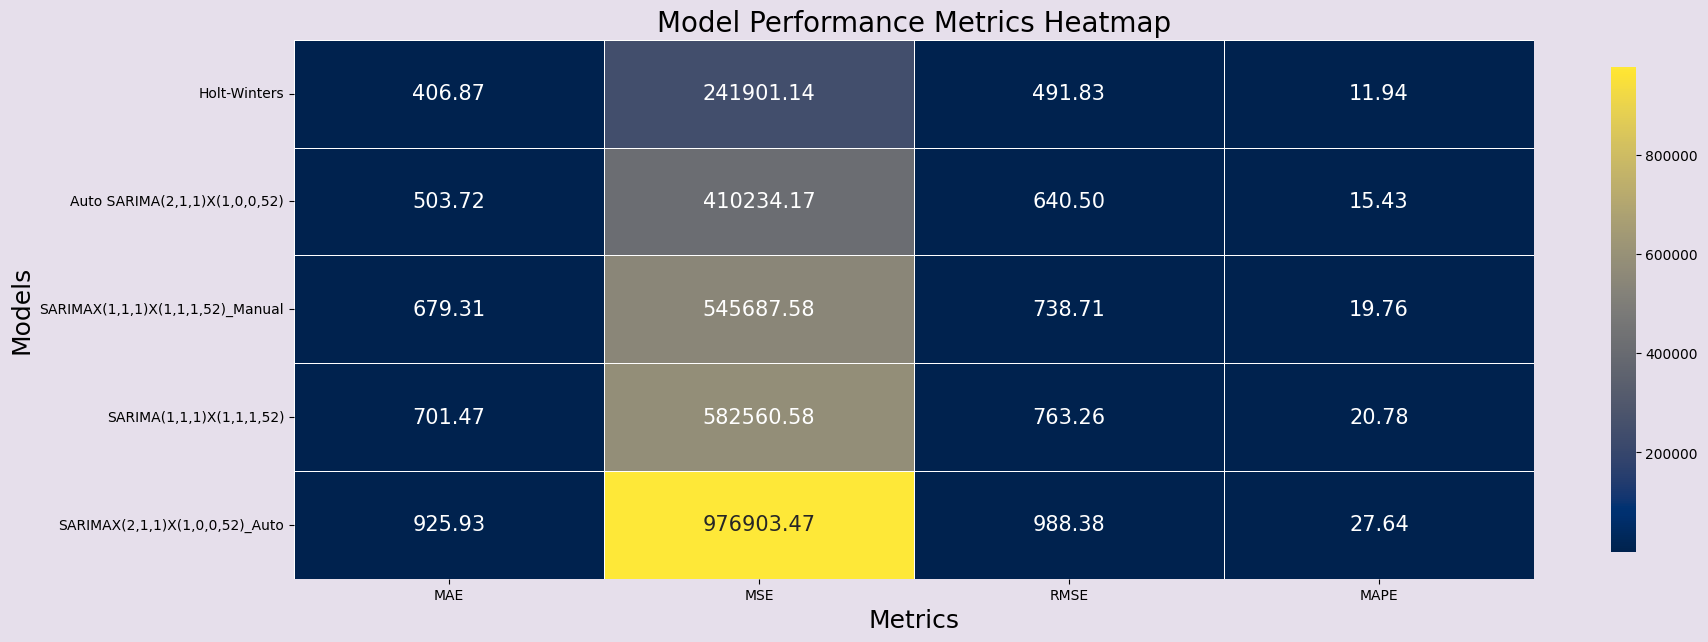

In [115]:
fig = plt.figure(figsize=(20,7), facecolor = '#e6dfeb')
axes = plt.subplot2grid((1,1),(0,0))

sns.heatmap(
    data = model_results_df, cmap='cividis', annot = True,fmt='.2f', annot_kws={"size": 15},  
    cbar_kws={"shrink": 0.9},  linewidths=0.5,  linecolor='white')
plt.xlabel('Metrics', fontsize=18)
plt.ylabel('Models', fontsize=18)
plt.title('Model Performance Metrics Heatmap', fontsize=20)
plt.show()

In [51]:
with open("../Saved_Models/hw_fitted_model.pkl", "wb") as file:
    pickle.dump(hw_fitted_model, file)

In [62]:
with open("../Saved_Models/auto_sarima_model.pkl", "wb") as file:
    pickle.dump(auto_model, file)

In [116]:
model_results_df.to_csv("../Saved_Models/model_results.csv", index=False)
print("DataFrame saved as 'model_results.csv'")

DataFrame saved as 'model_results.csv'
